In [1]:
#imports
import jax.numpy as np
import matplotlib.pyplot as plt
import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling, ShiftBounds
from pzflow.distributions import Uniform, Joint, Normal
import pandas as pd
import GCRCatalogs
import numpy as onp
import time
import seaborn as sns
start = time.process_time()

/global/homes/a/agaglian/.conda/envs/pzflow/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/global/homes/a/agaglian/.conda/envs/pzflow/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
def f(logmass):
    return 2*logmass - 24

cosmo=GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
#quantities = ['redshift', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'Mag_true_g_lsst_z0', 'Mag_true_r_lsst_z0', 'Mag_true_i_lsst_z0', 'Mag_true_z_lsst_z0', 
# 'stellar_mass', 'totalStarFormationRate']
quantities = ['redshift', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'stellar_mass', 'totalStarFormationRate']

print("Reading CosmoDC2 small catalog")
gal = cosmo.get_quantities(quantities)
print("Catalog read.")

Reading CosmoDC2 small catalog
Catalog read.


In [3]:
data_unscaled = {}
data_unscaled['logSFRtot'] = np.log10(gal['totalStarFormationRate'])
data_unscaled['redshift']  = gal['redshift']
data_unscaled['logmass'] = np.log10(gal['stellar_mass'])
#data_unscaled['Mag_true_g_lsst_z0']  = gal['Mag_true_g_lsst_z0']
#data_unscaled['Mag_true_r_lsst_z0']  = gal['Mag_true_r_lsst_z0']
#data_unscaled['Mag_true_i_lsst_z0']  = gal['Mag_true_i_lsst_z0']
#data_unscaled['Mag_true_z_lsst_z0']  = gal['Mag_true_z_lsst_z0']
data_unscaled['mag_true_g_lsst']  = gal['mag_true_g_lsst']
data_unscaled['mag_true_r_lsst']  = gal['mag_true_r_lsst']
data_unscaled['mag_true_i_lsst']  = gal['mag_true_i_lsst']
data_unscaled['mag_true_z_lsst']  = gal['mag_true_z_lsst']
# data_unscaled['morphology/totalEllipticity'] = gal['morphology/totalEllipticity']

data_unscaled = pd.DataFrame(data_unscaled)

#get rid of that weird clump M* > 10^10 Msol and logSFR = -5
data_unscaled = data_unscaled[onp.asarray((data_unscaled['logSFRtot'] - 9) > f(data_unscaled['logmass']))]
data_unscaled['g-r'] = data_unscaled['mag_true_g_lsst'] - data_unscaled['mag_true_r_lsst']
data_unscaled['r-i'] = data_unscaled['mag_true_r_lsst'] - data_unscaled['mag_true_i_lsst']
data_unscaled['i-z'] = data_unscaled['mag_true_i_lsst'] - data_unscaled['mag_true_z_lsst']

In [4]:
# standard scale the reference magnitude and colors
#data = data_unscaled.copy()
for quality in ['logmass', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'g-r', 'r-i', 'i-z']:
    data_unscaled[quality] = (data_unscaled[quality]-data_unscaled[quality].mean())/data_unscaled[quality].std()

In [5]:
del gal

In [6]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [7]:
# take a subset of 1/500th
# have tried 1/1000, 1/100,
data_subset = data_unscaled.sample(n=int(len(data_unscaled)/5.e2))

In [8]:
print(data_subset)

           logSFRtot  redshift   logmass  mag_true_g_lsst  mag_true_r_lsst  \
149710575   8.070707  1.834731  0.195719        -0.890332        -0.711134   
187663652   3.042732  2.385468 -0.404871         1.592921         1.411532   
52948413    6.184207  1.872177 -0.981391         0.767333         1.004770   
78432964    5.502950  1.844794  1.467780        -0.695386        -0.665696   
81143772    4.880201  1.271088 -0.397476         0.753054         0.600371   
...              ...       ...       ...              ...              ...   
38924411    6.425420  0.560915 -0.579345        -0.444266        -0.675993   
4908934     3.876606  0.330947  0.433751        -1.283065        -1.834353   
141702753   7.818971  1.649412  1.358359        -0.954980        -0.844232   
284761051   8.133856  2.003902  0.810661        -0.966039        -0.786198   
5808523     4.144999  0.723780 -1.008677        -0.146686        -0.288076   

           mag_true_i_lsst  mag_true_z_lsst       g-r       r-i

In [9]:
print('Training on {} CosmoDC2 galaxies.'.format(len(data_subset)))
conditional_columns = data_subset.columns.drop(['redshift', 'logSFRtot'])
latent = Uniform((-5,5),(-5,5)) 
#means = np.array([data_subset['redshift'].mean(), data_subset['logSFRtot'].mean()])
#stds = np.array([data_subset['redshift'].std(), data_subset['logSFRtot'].std()]) #switched 1/6 to 1/5.9
mins = np.array([data_subset['redshift'].min(), data_subset['logSFRtot'].min()])
maxs = np.array([data_subset['redshift'].max(), data_subset['logSFRtot'].max()]) #switched 1/6 to 1/5.9

bijector = Chain(
    ShiftBounds(mins, maxs, 4.9),
    RollingSplineCoupling(nlayers=2, n_conditions=len(conditional_columns), K=2),
)

Training on 585289 CosmoDC2 galaxies.


Training 30 epochs 
Loss:
(0) 3.8436
(1) -0.1890
(2) -0.6997
(3) -0.6057
(4) -0.9700
(5) -1.0239
(6) -1.1200
(7) -1.1993
(8) -1.3116
(9) -1.1118
(10) -1.3658
(11) -1.3380
(12) -1.5887
(13) -1.4657
(14) -1.5993
(15) -1.5515
(16) -1.4621
(17) -1.6798
(18) -1.6357
(19) -1.6373
(20) -1.8068
(21) -1.6507
(22) -1.7945
(23) -1.8987
(24) -1.8488
(25) -1.9139
(26) -1.8389
(27) -1.9434
(28) -2.0034
(29) -1.9757
(30) -1.9508


Text(0, 0.5, 'Training loss')

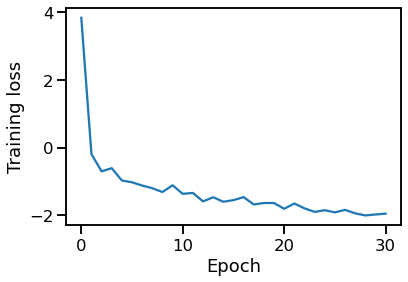

In [10]:

# To create the conditional flow, we have to provide
# 1. The names of the data columns
# 2. The bijector
# 3. The names of the conditional columns

flow = Flow(
    data_columns = ("redshift", "logSFRtot"),
    conditional_columns = conditional_columns,
    bijector = bijector,
    latent = latent,          
)

losses = flow.train(data_subset, epochs=30, verbose=True)

sns.set_context("talk")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
#plt.savefig("../plots/pzflow_traning_loss.png")
## save the results, then apply them with the script apply_pzflow_dc2full.py
#flow.save('../data_files/pzflow_dc2small_nofilter_div500')
#print("CPU time taken: ", time.process_time() - start)

In [11]:
allSamples = []
#split into 100 chunks
data_list = split_dataframe(data_subset, chunk_size=int(len(data_subset)/100.))

for chunk in data_list:
    samples = flow.sample(1, conditions=chunk.drop(columns=['redshift']), seed=0)
    allSamples.append(samples)
samples=pd.concat(allSamples)

In [12]:
samples

,redshift,logSFRtot,logmass,mag_true_g_lsst,mag_true_r_lsst,mag_true_i_lsst,mag_true_z_lsst,g-r,r-i,i-z
149710575,1.847479,8.102903,0.195719,-0.890332,-0.711134,-0.530702,-0.405274,-1.063865,-0.972614,-0.885529
187663652,2.414247,4.697782,-0.404871,1.592921,1.411532,1.339810,1.285336,1.374507,0.278291,0.204942
52948413,1.966950,5.155246,-0.981391,0.767333,1.004770,1.031617,0.987878,-0.571197,-0.253145,0.171037
78432964,1.868021,5.919971,1.467780,-0.695386,-0.665696,-0.640393,-0.691248,-0.412270,-0.076566,0.490894
81143772,1.311801,3.712948,-0.397476,0.753054,0.600371,0.295535,0.013922,0.903867,1.713028,2.121566
...,...,...,...,...,...,...,...,...,...,...
38924411,0.547075,5.869590,-0.579345,-0.444266,-0.675993,-0.693066,-0.594430,0.688417,0.170482,-0.653252
4908934,0.368720,4.807123,0.433751,-1.283065,-1.834353,-1.925500,-1.903323,1.540539,0.716748,0.131541
141702753,1.779820,7.466048,1.358359,-0.954980,-0.844232,-0.826798,-0.808333,-0.831808,-0.012973,-0.013978
284761051,1.961157,8.256520,0.810661,-0.966039,-0.786198,-0.669443,-0.611115,-1.098909,-0.595407,-0.346232


In [13]:
data_subset['redshift_old'] = data_subset['redshift']
data_subset['logSFRtot_old'] = data_subset['logSFRtot']

In [14]:
data_subset['redshift_new'] = samples['redshift']
data_subset['logSFRtot_new'] = samples['logSFRtot']

(array([7.40000e+01, 2.73000e+02, 1.05000e+03, 3.15500e+03, 4.47118e+05,
        1.26450e+05, 3.31300e+03, 1.62500e+03, 1.17400e+03, 1.05700e+03]),
 array([-2.97087293, -2.36958201, -1.76829109, -1.16700017, -0.56570925,
         0.03558167,  0.63687259,  1.23816351,  1.83945443,  2.44074535,
         3.04203627]),
 <a list of 10 Patch objects>)

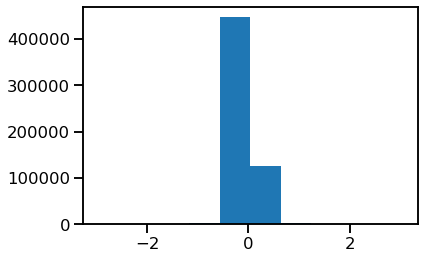

In [15]:
plt.hist(data_subset['redshift_old'] - data_subset['redshift_new'])

Text(0, 0.5, '$g-r$')

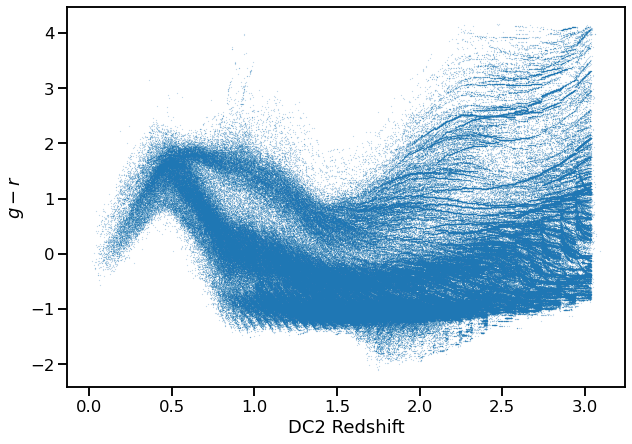

In [23]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_old'], data_subset['g-r'], 'o', ms=0.1)
plt.xlabel("DC2 Redshift")
plt.ylabel(r"$g-r$")

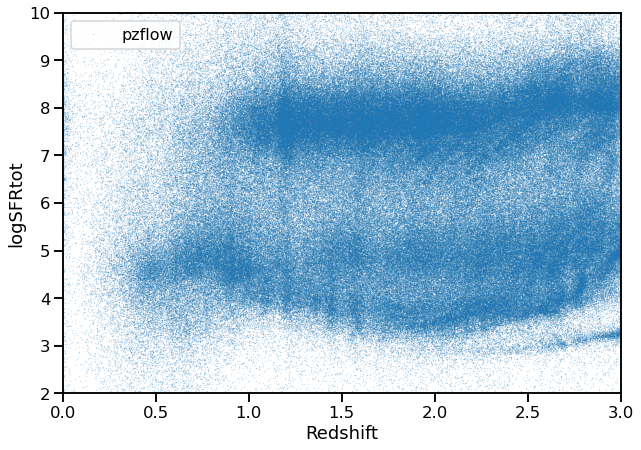

In [17]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_new'], data_subset['logSFRtot_new'], 'o', ms=0.3, alpha=0.3, label=r'pzflow')
#plt.plot(data_subset['redshift_old'], data_subset['logSFRtot_old'], 'o', ms=0.3, alpha=0.3, label=r'DC2')
plt.legend(fontsize=16)
plt.ylim((2, 10))
plt.xlim((0, 3))
#plt.xlabel("DC2 Redshift")
plt.xlabel("Redshift");
plt.ylabel(r"logSFRtot");

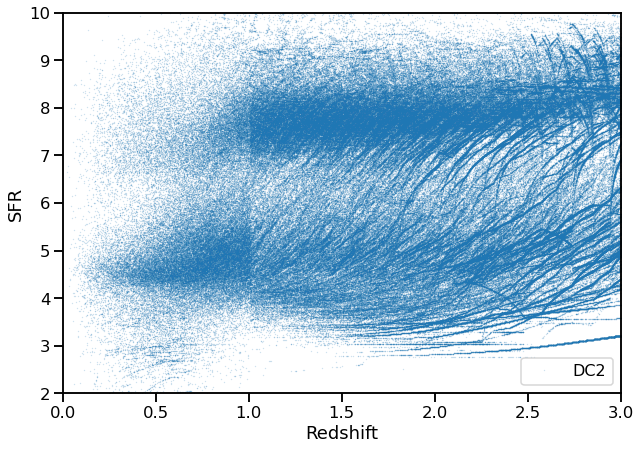

In [18]:
plt.figure(figsize=(10,7))
#plt.plot(data_subset['redshift_new'], data_subset['logSFRtot_new'], 'o', ms=0.3, alpha=0.3, label=r'pzflow')
plt.plot(data_subset['redshift_old'], data_subset['logSFRtot_old'], 'o', ms=0.3, alpha=0.3, label=r'DC2')
plt.legend(fontsize=16)
plt.ylim((2, 10))
plt.xlim((0, 3))
#plt.xlabel("DC2 Redshift")
plt.xlabel("Redshift");
plt.ylabel(r"SFR");

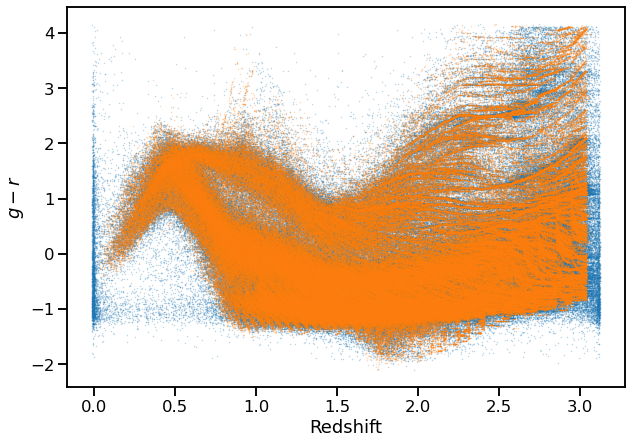

In [19]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_new'], data_subset['g-r'], 'o', ms=0.5, alpha=0.3, label=r'pzflow')
plt.plot(data_subset['redshift_old'], data_subset['g-r'], 'o', ms=0.5, alpha=0.3, label=r'DC2')
#plt.xlabel("DC2 Redshift")
plt.xlabel("Redshift");
plt.ylabel(r"$g-r$");

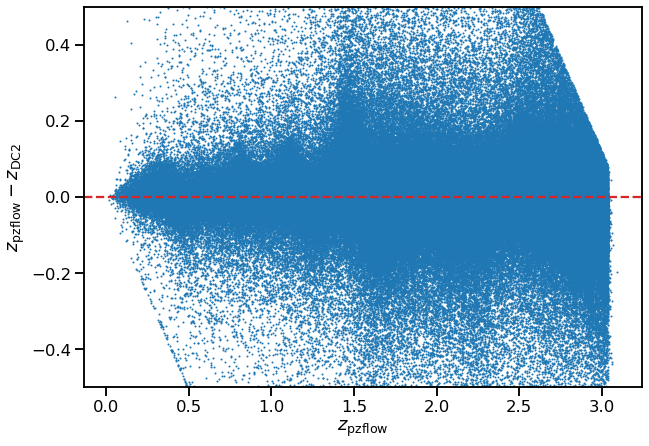

In [20]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_old'], data_subset['redshift_new'] - data_subset['redshift_old'], 'o', ms=1)
plt.xlabel(r"$z_{\rm pzflow}$")
plt.ylim((-0.5, 0.5))
plt.axhline(y=0, ls='--', c='tab:red')
plt.ylabel(r"$z_{\rm pzflow} - z_{\rm DC2}$");

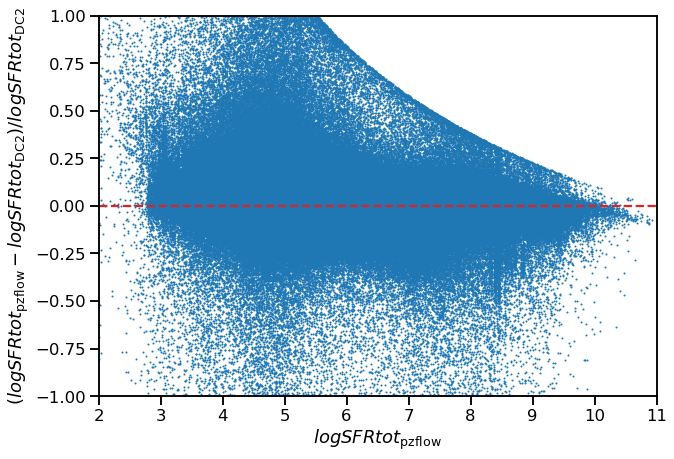

In [21]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['logSFRtot_old'], (data_subset['logSFRtot_new'] - data_subset['logSFRtot_old'])/data_subset['logSFRtot_old'], 'o', ms=1)
plt.xlabel(r"$logSFRtot_{\rm pzflow}$")
plt.ylim((-1, 1))
plt.xlim((2, 11))
plt.axhline(y=0, ls='--', c='tab:red')
plt.ylabel(r"($logSFRtot_{\rm pzflow} - logSFRtot_{\rm DC2}$)/$logSFRtot_{\rm DC2}$");

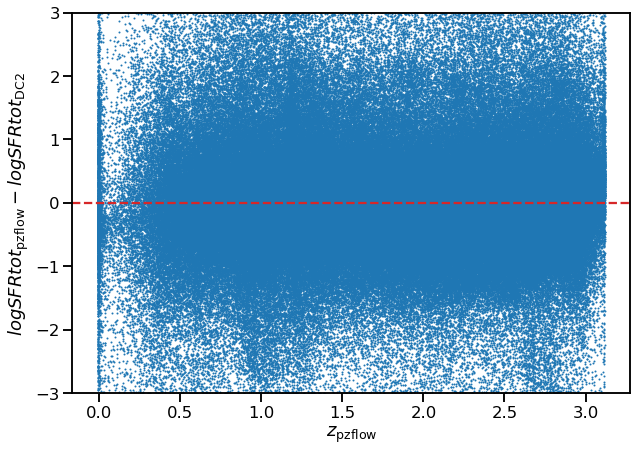

In [22]:
plt.figure(figsize=(10,7))
plt.plot(data_subset['redshift_new'], data_subset['logSFRtot_new'] - data_subset['logSFRtot_old'], 'o', ms=1)
plt.xlabel(r"$z_{\rm pzflow}$")
#plt.xlim((2, 10))
plt.ylim((-3, 3))
plt.axhline(y=0, ls='--', c='tab:red')
plt.ylabel(r"$logSFRtot_{\rm pzflow} - logSFRtot_{\rm DC2}$");